identify domains in 3-component system using Voronoi edge method to determine neighbors and Lo/Ld; label domains and identify which lipid in each one; set min domain size
then, look for fraction of registration across leaflets
mdw 10/17/2016

In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
#import scipy.cluster.hierarchy
import scipy.spatial

In [3]:
traj=md.load('DBPC_Rho=ptsix_mdProduction_2us.gro',top='DBPC_Rho=ptsix_mdProduction_2us.gro',stride=1)

/Users/naveen/anaconda/lib/python2.7/site-packages/mdtraj/core/trajectory.py:417: UserWarning: top= kwarg ignored since file contains topology information
  warnings.warn('top= kwarg ignored since file contains topology information')


In [4]:
traj.n_frames


1

In [5]:
topology=traj.topology
allhead=topology.select('name PO4 or name ROH')

In [6]:
resnames=[atom.residue.name for atom in topology.atoms]

In [84]:
#x,y coordinates of all for finding neighbors to determine local midplane z-value
# here, best to use xy radius of neighbors, since Voronoi across 2 leaflets could have complications
#N: putting eaching atom into a seperate array and then adding every atom into that same array. 

allheadxy=[]
allheadz=[]
##for nn in range(traj.n_frames):
##    headxy[nn]=list([] for _ in xrange(uppertotal))
for i in range(len(allhead)):
    allheadi=allhead[i]
    allheadxy.append(traj.xyz[0][allheadi][0:2:1])
    allheadz.append(traj.xyz[0][allheadi][2])


In [85]:
# mdtraj can't handle neighbors for gro (rather than xtc) inputs, so do it myself
#N: cut off all faraway neighbors so there is just a "group" = an atom plus its close neighbors
cutoffsq = 2.4**2; #square of maximum xy distance for neighbors

neigh=list([] for _ in xrange(len(allheadxy)))


for i in range(len(allheadxy)):
    xyi=allheadxy[i]
    for j in range(len(allheadxy)-i-1): #not self, but will add for midplane finding
        xyj=allheadxy[j+i+1]
        distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
        if (distsq < cutoffsq):
            neigh[i].append(j+i+1)
            neigh[j+i+1].append(i)
        





In [86]:
#use neigh (flat) to calculate local midplane through median z-value of heads
#N: Calculate the midplane through each head 
midplane=list([] for _ in xrange(len(allheadz)))
for i in range(len(allheadz)):
    localzs=[]
    localzs.append(allheadz[i]) # include self
    for j in range(len(neigh[i])):
        localzs.append(allheadz[neigh[i][j]])
    midplane[i]=(min(localzs)+max(localzs))/2.0

In [87]:
#have array with values placing each head in one leaflet: 0=lower, 1=upper, 2=between
#N: Using each midplane vector, determine if the head is in the uppper, lower, or between leaflet
head_leaflet=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    head_leaflet[nn]=list([] for _ in xrange(len(allhead)))
for i in range(len(allhead)):
    if allheadz[i]<midplane[i]-0.1:
        head_leaflet[0][i]=0
    elif allheadz[i]>midplane[i]+0.1:
        head_leaflet[0][i]=1
    else:
        head_leaflet[0][i]=2
    
    

In [88]:
# only need upper leaflet heads for this situation
#N: Discard middle and between. Only going to analyze upper leaflet
upperheads=[]
for i in range(len(allhead)):
    if head_leaflet[0][i]==1:
        upperheads.append(allhead[i])

In [89]:
#count DPPC as fraction of upper total, to find global concentration of DPPC
#upperdppc=list([] for _ in xrange(traj.n_frames))
#uppertotal=list([] for _ in xrange(traj.n_frames))
#globalconc=list([] for _ in xrange(traj.n_frames))

upperdppc=0
for j in range(len(upperheads)):
    if(resnames[upperheads[j]]=='DBPC' or resnames[upperheads[j]]=='CHOL'):
        upperdppc=upperdppc+1
globalconc=float(upperdppc)/len(upperheads)


In [90]:
#x,y coordinates of outer for Voronoi
#headxy=list([] for _ in xrange(traj.n_frames)) #[frame][head]
headxy=[]
##for nn in range(traj.n_frames):
##    headxy[nn]=list([] for _ in xrange(uppertotal))
for i in range(len(upperheads)):
    upperheadsi=upperheads[i]
 #   for j in range(traj.n_frames):
 #   if (head_leaflet[0][i]==1):
    headxy.append(traj.xyz[0][upperheadsi][0:2:1])


In [91]:
vor=scipy.spatial.Voronoi(np.array(headxy))
#scipy.spatial.voronoi_plot_2d(vor)


In [92]:
#Voronoi neighbors vneigh

#generate list of neighbors, edgeneigh
edgeneigh=list([] for _ in xrange(len(upperheads)))
for k in range(len(vor.ridge_points)):
    pair=vor.ridge_points[k]
    edgeneigh[pair[0]].append(pair[1])
    edgeneigh[pair[1]].append(pair[0])



vneigh=list([] for _ in xrange(len(upperheads))) #need two deep (x num frames) #lipid type
vneighres=list([] for _ in xrange(len(upperheads)))
#only frame 8, for now
for i in range(len(upperheads)):
#    upperheadi=upperheads[i]
    vneighheads=edgeneigh[i] #upperhead index, not atom
    if not vneighheads:
        vneigh[i]=[]
        vneighres[i]=[]
    else:
        for j in range(len(vneighheads)):
            vneigh[i].append(resnames[upperheads[vneighheads[j]]])
            vneighres[i].append(vneighheads[j])







In [93]:
#phase based on edges
vphase=list([] for _ in xrange(len(upperheads)))
for i in range(len(upperheads)): #N: cylcing through every molecule head group
    vneightot=1+len(vneigh[i]) #include self; N: The number of neighbors is 1+what Voroni decided
    num_sat=0 #some integer set to 0
    if (resnames[upperheads[i]]=='DBPC' or resnames[upperheads[i]]=='CHOL'):#N: See if the molecule head is DBPC/CHOL
            num_sat=num_sat+1 #N: If either add +1 to the integer. We have determined the composition of the head. 
    for j in range(len(vneigh[i])): #N: Now look at its neighbors according to Voroni.
        if (vneigh[i][j]=='DBPC' or vneigh[i][j]=='CHOL'): #N: Are the neighbors DBPC/CHOL?
            num_sat=num_sat+1 #N: If so, add +1 to the integer
    vlocal_conc=float(num_sat)/vneightot #integer would always be zero. 
          #N: Find Ratio of DBPC 'polygon groups' to the total looked at. ie the ones it touches
    if (vlocal_conc > globalconc):
        vphase[i] = 1 # Lo=1 #N: If this local concentration is > global, we are calling in Lo=DBPC
    else:
        vphase[i] = 0 # Ld=0 #N: If local concentration is < global, we are calling it Ld=DIPC
        

In [94]:
#iterate edge-based phase determination to reduce small clusters
#N: Going to do the whole process again. Now we have larger decidely homogenous domains. Reduce small clusters
vphase2=list([] for _ in xrange(len(upperheads)))
for i in range(len(upperheads)): #N: cycling through every molecule head group in upper membrane
    vneightot=1+len(vneigh[i])  
    num_lo=0
    if (vphase[i]==1): #N: We don't have to check whether the head is Lo or LD, b/c we already determined that previously
        num_lo=num_lo+1 #N: Now, our groups are larger, to include a small homogenous patch. Comparing patch to patch.
    for j in range(len(vneigh[i])):
        if(vphase[vneighres[i][j]]==1):
            num_lo=num_lo+1
    vlocal_conc=float(num_lo)/vneightot
    if (vlocal_conc > 0.49):#N: Why not global concentration? Just saying if Lo #of patches> Ld #of patches, call it Lo
        vphase2[i]=1
    else:
        vphase2[i]=0

In [95]:
#iterate edge-based phase determination to reduce small clusters
#N: Iteration 3
vphase3=list([] for _ in xrange(len(upperheads)))
for i in range(len(upperheads)):
    vneightot=1+len(vneigh[i])
    num_lo=0
    if (vphase2[i]==1):
        num_lo=num_lo+1
    for j in range(len(vneigh[i])):
        if(vphase2[vneighres[i][j]]==1):
            num_lo=num_lo+1
    vlocal_conc=float(num_lo)/vneightot
    if (vlocal_conc > 0.49):
        vphase3[i]=1
    else:
        vphase3[i]=0

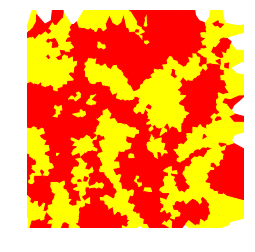

In [102]:
# color Voronoi polygons
#N: Make a nice picture
fig,ax=plt.subplots(1)
patches=[]
cmap=plt.get_cmap('autumn')
#flatphase=[val for sublist in cphase for val in sublist]
#colors=cmap([x*10 for x in flatphase])
colors=cmap([(x*256) for x in vphase])
#for region in range(len(vor.regions)):
#    if not -1 in vor.regions[region]:
#        pg=Polygon(vor.vertices,closed=True)
#        patches.append(pg)




for i in range(len(vor.point_region)):
    verts=vor.regions[vor.point_region[i]] #indices of vertices forming that region
    if (verts==[]):
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    elif (not -1 in verts):
        vertcoord=list([] for _ in xrange(len(verts))) #coordinates of vertices
        for j in range(len(verts)):
            k=verts[j]
            vertcoord[j]=vor.vertices[k]
        pg=Polygon(vertcoord,closed=True)
        patches.append(pg)
    else:
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    



collection=PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
        
#plt.fill(*zip(*pg))
ax.set_aspect('equal')
ax.set_xlim([0,36.5])
ax.set_ylim([0,36.5])

plt.axis('off')

#plt.savefig('DBPC_Rho=ptsix_1us_phases.pdf',format='pdf')
plt.show()

In [97]:
# identify and number domains, then determine which are too small
# start with 1st lipid, call domain 1, label all neighbors in same phase as also domain 1,...
# reserve domain 0 for unassigned, so 1 is 1st domain

In [103]:
domain=list([] for _ in xrange(len(upperheads)))
for i in range(len(upperheads)): #N: Cycling through all molecule heads
    domain[i]=0 # 0 = unassigned; N: Assigning each domain a value of 0

recurlist=[] # list of heads that must run through domain algorithm because in chain of neighbors
    
domain[0]=1 # first lipid sets first domain
for i in range(len(vneighres[0])): # vneighres is allheadz index, not atom
    ni=vneighres[0][i] #N: Looking at specific patch
    if vphase[ni]==vphase[0]: #only neighbors in same phase; N: Check if they have the same phase
        domain[ni]=1 #N: If same phase, domain of that patch becomes 1
        recurlist.append(ni) #N: Add it the heads that need to be checked against their neighbors
num_domains=1

while len(recurlist): # no new domain should be introduced in this section
    headi=recurlist[0] #N: Looking at the first entry in recurlist
    neighi=vneighres[headi] #N: Finding its neighbors
    recurlist=recurlist[1:] # remove 1st element, now being handled
    for j in range(len(neighi)):#N: For all of its neighbors
        ni=neighi[j] 
        if (vphase[ni]==vphase[headi] and domain[ni]==0): #avoid infinitely putting back into recurlist; N: is the phase same as domian
            domain[ni]=domain[headi] #N: Domain is the same as the head
            recurlist.append(ni) #N: Put it back in the list to be checked again

#now iterate over other lipids, excluding those already marked
for i in range(len(upperheads)-1): # 0 already done
    if domain[i+1]==0: #not yet marked
        neighi=vneighres[i+1]
        num_domains=num_domains+1
        domain[i+1]=num_domains
        for j in range(len(neighi)):
            ni=neighi[j]
            if vphase[ni]==vphase[i+1]:
                domain[ni]=domain[i+1] 
                recurlist.append(ni)
        while len(recurlist): #until exhausted, then move onto next new domain
            headi=recurlist[0]
            neighi=vneighres[headi]
            recurlist=recurlist[1:]
            for j in range(len(neighi)):
                ni=neighi[j]
                if (vphase[ni]==vphase[headi] and domain[ni]==0):
                    domain[ni]=domain[headi]
                    recurlist.append(ni)
        
    
    


In [105]:
max(domain)

37

In [100]:
vneighres[-1]

[972, 834, 827, 1419, 1990]

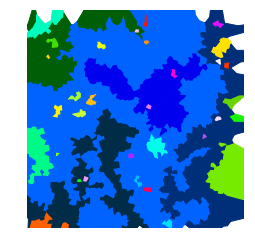

In [107]:
# color Voronoi polygons by domain number
fig,ax=plt.subplots(1)
patches=[]
cmap=plt.get_cmap('gist_ncar')
#flatphase=[val for sublist in cphase for val in sublist]
#colors=cmap([x*10 for x in flatphase])
colors=cmap([x/37. for x in domain])
#for region in range(len(vor.regions)):
#    if not -1 in vor.regions[region]:
#        pg=Polygon(vor.vertices,closed=True)
#        patches.append(pg)




for i in range(len(vor.point_region)):
    verts=vor.regions[vor.point_region[i]] #indices of vertices forming that region
    if (verts==[]):
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    elif (not -1 in verts):
        vertcoord=list([] for _ in xrange(len(verts))) #coordinates of vertices
        for j in range(len(verts)):
            k=verts[j]
            vertcoord[j]=vor.vertices[k]
        pg=Polygon(vertcoord,closed=True)
        patches.append(pg)
    else:
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    



collection=PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
        
#plt.fill(*zip(*pg))
ax.set_aspect('equal')
ax.set_xlim([0,36.5])
ax.set_ylim([0,36.5])

plt.axis('off')

plt.savefig('DBPC_vphase_Rho=ptsix_1us_domains_adjust_pbc&size.pdf',format='pdf')
plt.show()